# Predicting Memorability

Below is a complete example of predicting the video memorability using the video captions with a simple 3-layer NN to get you started. 

Note:

*   You don't have to use the same framework as used here
*   Try out some other variations on this model. (layers, features etc.)
*   Use this as a guide example, not the solution. 




**Some very useful functions for colabs! **

You need to calculate the Spearman score eventually

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

If working on Colabs I would suggest mapping your drive. It helps load the data in from Google Drive.

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684_Machine Learning Data/dev-set/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Install this package if you are missing it. Similar to tqdm.

# Predicting video memorability using captions (Jointly)

In [5]:
!pip install numpy

In [0]:
# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [0]:
import pandas as pd

## 1. Loading the captions and the memorability scores

In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = './dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = './'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

In [0]:
print(df_cap)

               video                                            caption
0        video3.webm                 blonde-woman-is-massaged-tilt-down
1        video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2        video6.webm                                      khr-gangsters
3        video8.webm               medical-helicopter-hovers-at-airport
4       video10.webm               couple-relaxing-on-picnic-crane-shot
5       video12.webm                       passing-by-older-man-reading
6       video13.webm      christmas-village-and-national-christmas-tree
7       video16.webm  unhappy-friends-looking-for-something-interest...
8       video17.webm                        hoover-dam-tourists-traffic
9       video18.webm  happy-girl-stretching-and-relaxing-on-the-station
10      video19.webm                              bread-on-the-conveyor
11      video20.webm  close-up-on-racks-of-computer-equipment-with-f...
12      video21.webm                    modern-family-overdue-bu

In [9]:
print(labels)

               video  short-term_memorability  nb_short-term_annotations  \
0        video3.webm                    0.924                         34   
1        video4.webm                    0.923                         33   
2        video6.webm                    0.863                         33   
3        video8.webm                    0.922                         33   
4       video10.webm                    0.950                         34   
5       video12.webm                    0.783                         74   
6       video13.webm                    0.861                         40   
7       video16.webm                    0.834                         33   
8       video17.webm                    0.777                         43   
9       video18.webm                    0.863                         33   
10      video19.webm                    0.980                         55   
11      video20.webm                    0.955                         40   
12      vide

In [0]:
from collections import Counter

In [11]:
!pip install pyprind

In [12]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [13]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #print( "Text: {}".format(text) )                      #print( "Caption: {}".format(df_cap.loc[i,'caption']) )
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


In [14]:
print(counts)
print(len(counts))

Counter({'in': 2105, 'the': 1835, 'on': 1724, 'and': 1444, 'a': 1181, 'with': 996, 'woman': 899, 'of': 836, 'at': 762, 'young': 724, 'man': 559, 'slow': 495, 'motion': 452, 'to': 416, 'couple': 318, 'sitting': 304, 'girl': 291, 'happy': 279, 'beach': 270, 'park': 256, 'up': 255, 'walking': 237, 'close': 230, 'camera': 230, 'her': 219, 'using': 218, 'shot': 215, 'smiling': 198, 'looking': 195, 'two': 191, 'by': 189, 'people': 188, 'from': 188, 'tablet': 184, 'is': 181, 'water': 171, 'through': 156, 'female': 150, 'computer': 149, 'view': 149, 'laptop': 139, 'playing': 137, 'sunset': 137, 'beautiful': 133, 'videoblocks': 131, 'his': 131, 'running': 130, 'talking': 129, 'city': 128, 'working': 127, 'eating': 126, 'little': 126, 'family': 125, 'mother': 124, 'background': 122, 'home': 122, 'standing': 121, 'for': 115, 'phone': 115, 'or': 114, 'sea': 113, 'national': 112, 'african': 111, 'attractive': 111, 'tree': 107, 'snow': 103, 'their': 102, 'drinking': 102, 'hands': 102, 'steadicamof':

In [15]:
df_cap.head()

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


## 2. Preprocessing the captions for model inputs
### Separate words and count each word's occurrence

### Maping each unique word to an integer (one-hot encoding)

In [16]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
print(len_token)

5191


In [0]:
tokenizer.fit_on_texts(list(df_cap.caption.values)) #fit a list of captions to the tokenizer
#the tokenizer vectorizes a text corpus, by turning each text into either a sequence of integers 

In [18]:
print(len(tokenizer.word_index))

5191


In [0]:
one_hot_res = tokenizer.texts_to_matrix(list(df_cap.caption.values),mode='binary')
sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))

In [20]:
#Just to visualise some stuff in sequences and counts
print(sequences[0]) # prints location of words from caption 0 'blonde woman is massaged tilt down'
print(counts['blonde']) # no. of occurences of 'blonde'
n=3
print('Least Common: ', counts.most_common()[:-n-1:-1])       # n least common elements
print('Most Common: ',counts.most_common(n))                     # n most common elements

[724, 7, 35, 884, 384, 91]
10
Least Common:  [('unknown', 1), ('handheldshowing', 1), ('longof', 1)]
Most Common:  [('in', 2105), ('the', 1835), ('on', 1724)]


### Making all the sequences same length by padding zeros from 1 to (N - len(seq))

In [0]:
# calculating max length
max_len = 50

### Making sequences index same length

In [22]:
print(sequences[0]) # length of 1st sequence

[724, 7, 35, 884, 384, 91]


In [23]:
np.zeros

<function numpy.zeros>

In [24]:
X_seq = np.zeros((len(sequences),max_len))
for i in range(len(sequences)):
    n = len(sequences[i])
    if n==0:
        print(i)
    else:
        X_seq[i,-n:] = sequences[i]
X_seq.shape

(6000, 50)

In [25]:
print(X_seq[5999,:])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  44.  71.
 243.   7.  26.  34.  39.   1. 872. 222.]


In [26]:
print(X_seq[0,:]) # length of 1st sequence after padding the caption with zeros.

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 724.   7.  35. 884. 384.  91.]


***One hot encoding are already same length so no need to change***

## 3. Building network model - using Keras library


**Remember: Split data set to training and test data**

The targets here are the short-term and long-term scores

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values # targets
X = X_seq # sequences

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

**Look at the shape of our data for some context**

In [29]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 50)
X_test (1200, 50)
Y_train (4800, 2)
Y_test (1200, 2)


###Construction

A dense layer is just a regular layer of neurons in a NN. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. 


![alt text](http://www.ece.utep.edu/research/webfuzzy/docs/kk-thesis/kk-thesis-html/img33.gif)


The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. The following is the docstring of class Dense from the keras documentation:

*output = activation(dot(input, kernel) + bias)*

where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

In [30]:
# add dropout - Helps prevent overfitting
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

model = Sequential() # The Sequential model is a linear stack of layers.

# You can simply add layers via the .add() method: l-
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,))) # Just your regular densely-connected NN layer.
model.add(layers.Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


###Compilation

Before training a model, you need to configure the learning process, which is done via the compile method. 

It receives three arguments:

1.   An optimizer
2.   A loss function
3.   A list of metrics


In [0]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

###Training

Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the *fit* function.

In [32]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 351us/step - loss: 0.3450 - acc: 0.6402 - val_loss: 0.3735 - val_acc: 0.7083
Epoch 2/20
4800/4800 [==============================] - 0s 101us/step - loss: 0.2665 - acc: 0.6338 - val_loss: 0.2872 - val_acc: 0.7083
Epoch 3/20
4800/4800 [==============================] - 0s 96us/step - loss: 0.1993 - acc: 0.6392 - val_loss: 0.1591 - val_acc: 0.7075
Epoch 4/20
4800/4800 [==============================] - 0s 100us/step - loss: 0.1429 - acc: 0.6392 - val_loss: 0.0996 - val_acc: 0.6992
Epoch 5/20
4800/4800 [==============================] - 0s 95us/step - loss: 0.0980 - acc: 0.6481 - val_loss: 0.0797 - val_acc: 0.6917
Epoch 6/20
4800/4800 [==============================] - 0s 100us/step - loss: 0.0675 - acc: 0.6502 - val_loss: 0.0530 - val_acc: 0.6867
Epoch 7/20
4800/4800 [==============================] - 0s 96us/step - loss: 0.0504 - acc:

### Visualising the validation and training loss

This is a basic way to help us to see if we are overfitting...
How?

Try train the model for a *LOT* more iterations and see what happens...

I would make sure to save the images, also a white background makes the plots look nice in your reports :). I'll let you figure out how to do that!

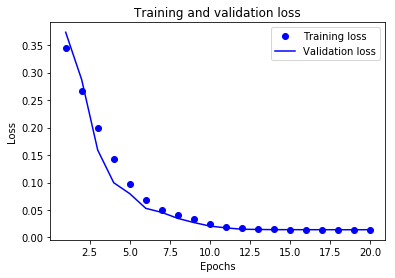

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

What is training and validation accuracy?

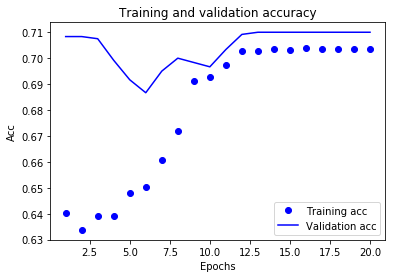

In [34]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


Okay lets make some predictions now on the newly trained model....

In [35]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

[[0.8634068  0.7801727 ]
 [0.8634218  0.78018343]
 [0.8672763  0.7829531 ]
 ...
 [0.8737861  0.7876918 ]
 [0.8993244  0.81890565]
 [0.8674631  0.7830884 ]]
The Spearman's correlation coefficient is: 0.065
The Spearman's correlation coefficient is: 0.033


Not great, but that's the point.. Now what can you do to improve this?

Maybe try a different model, the one used here is relatively simple. 

What about all the other features?

#4.  Predicting video memorability using captions (one-hot res)

Some nice one-hot encoding..
Not sure what it is? Read more [here](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

In [36]:
one_hot_res.shape

(6000, 5191)

Throwing everything into one big cell because we already broke it down in the previous section

In [37]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# add dropout
# add regularizers
model = Sequential()
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(len_token,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2,activation='relu'))

# compile the model 
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 202us/step - loss: 0.4186 - acc: 0.3790 - val_loss: 0.1152 - val_acc: 0.3342
Epoch 2/20
4800/4800 [==============================] - 1s 146us/step - loss: 0.1349 - acc: 0.5077 - val_loss: 0.0429 - val_acc: 0.6792
Epoch 3/20
4800/4800 [==============================] - 1s 134us/step - loss: 0.0823 - acc: 0.5721 - val_loss: 0.0296 - val_acc: 0.7067
Epoch 4/20
4800/4800 [==============================] - 1s 142us/step - loss: 0.0599 - acc: 0.5810 - val_loss: 0.0231 - val_acc: 0.7092
Epoch 5/20
4800/4800 [==============================] - 1s 139us/step - loss: 0.0473 - acc: 0.5898 - val_loss: 0.0211 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 1s 136us/step - loss: 0.0398 - acc: 0.6002 - val_loss: 0.0197 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 1s 139us/step - loss: 0.0349 - acc: 0.5931 - val_loss: 0.0182 - val_acc: 0.7100


In [38]:
predictions = model.predict(X_test)
print(predictions.shape)

(1200, 2)


In [0]:
Y_pred_train = model.predict(X_train)
#Y_pred_val = model.predict(X_test)

In [40]:
#print('='*20)
#print('Training Scores')
#Get_score(Y_pred_train,Y_train)
print('='*20)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.390
The Spearman's correlation coefficient is: 0.182


# Support Vector Regression & Logistic Regression

In [0]:
Y = labels[['short-term_memorability']].values # targets
X = one_hot_res # sequences
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

from sklearn.svm import SVR

#Create a svm Classifier
clf = SVR(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print('='*50)
print('Short Term Memorability Scores for SVR')
Get_score(y_pred, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Short Term Memorability Scores for SVR
The Spearman's correlation coefficient is: 0.334


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(Y_train)

logreg = LogisticRegression()
logreg.fit(X_train, encoded)
y_pred = logreg.predict(X_test)

print('='*50)
print('Short Term Memorability Scores for Logistic Regression')
Get_score(y_pred, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Short Term Memorability Scores for Logistic Regression
The Spearman's correlation coefficient is: 0.283


In [0]:
Y = labels[['long-term_memorability']].values # targets
X = one_hot_res # sequences
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

from sklearn.svm import SVR

#Create a svm Classifier
clf = SVR(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print('='*50)
print('Long Term Memorability Scores for SVR')
Get_score(y_pred, Y_test)

Long Term Memorability Scores for SVR
The Spearman's correlation coefficient is: 0.141


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Long Term Memorability Scores for SVR
The Spearman's correlation coefficient is: 0.141


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(Y_train)

logreg = LogisticRegression()
logreg.fit(X_train, encoded)
y_pred = logreg.predict(X_test)

print('='*50)
print('Long Term Memorability Scores for Logistic Regression')
Get_score(y_pred, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Long Term Memorability Scores for Logistic Regression
The Spearman's correlation coefficient is: 0.114


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Long Term Memorability Scores for Logistic Regression
The Spearman's correlation coefficient is: 0.114


# Predicting with Artificial Neural Network

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

model = Sequential()
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(220,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 220)               1142240   
_________________________________________________________________
dropout_34 (Dropout)         (None, 220)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 220)               48620     
_________________________________________________________________
dropout_35 (Dropout)         (None, 220)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 220)               48620     
_________________________________________________________________
dropout_36 (Dropout)         (None, 220)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 442       
Total para

In [0]:
from keras.optimizers import Nadam
opt=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(optimizer=opt,loss=['mae'],metrics=['acc'])
history=model.fit(x=X_train,y=Y_train,batch_size=50,epochs=20,validation_split=0.2,shuffle=True,verbose=True)

Train on 3840 samples, validate on 960 samples
Epoch 1/20
3840/3840 [==============================] - 2s 626us/step - loss: 0.3319 - acc: 0.5914 - val_loss: 0.1804 - val_acc: 0.6813
Epoch 2/20
3840/3840 [==============================] - 1s 182us/step - loss: 0.1755 - acc: 0.6419 - val_loss: 0.1251 - val_acc: 0.6813
Epoch 3/20
3840/3840 [==============================] - 1s 177us/step - loss: 0.1375 - acc: 0.6799 - val_loss: 0.1205 - val_acc: 0.6813
Epoch 4/20
3840/3840 [==============================] - 1s 191us/step - loss: 0.1206 - acc: 0.6924 - val_loss: 0.1066 - val_acc: 0.6813
Epoch 5/20
3840/3840 [==============================] - 1s 196us/step - loss: 0.1102 - acc: 0.7042 - val_loss: 0.0957 - val_acc: 0.6813
Epoch 6/20
3840/3840 [==============================] - 1s 166us/step - loss: 0.1041 - acc: 0.7091 - val_loss: 0.0936 - val_acc: 0.6813
Epoch 7/20
3840/3840 [==============================] - 1s 184us/step - loss: 0.0999 - acc: 0.7096 - val_loss: 0.0969 - val_acc: 0.6823
E

In [0]:
Y_pred = model.predict(X_test)

In [0]:
Get_score(Y_pred, Y_test)

The Spearman's correlation coefficient is: 0.440
The Spearman's correlation coefficient is: 0.145


# Simple Long short term memory

The Spearman's correlation coefficient is: 0.131
The Spearman's correlation coefficient is: 0.072 

In [0]:
print(one_hot_res[0].shape)

(5191,)


In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional



Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

print(X_train.shape)

(4800, 5191)


In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional



Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

X_train = X_train.reshape(1,4800,5191)
X_test = X_test.reshape(1,1200,5191)
Y_train = Y_train.reshape(1,4800,2)
Y_test = Y_test.reshape(1,1200,2)

model = Sequential()
# Recurrent layer
model.add(LSTM(128,batch_input_shape=(None,None,5191),return_sequences=True))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.4))

# Output layer
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 1 samples, validate on 1 samples
Epoch 1/20
1/1 [==============================] - 9s 9s/step - loss: 0.1162 - acc: 0.5179 - val_loss: 0.1071 - val_acc: 0.6250
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 0.1085 - acc: 0.5617 - val_loss: 0.0992 - val_acc: 0.6517
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 0.1004 - acc: 0.5808 - val_loss: 0.0898 - val_acc: 0.6608
Epoch 4/20
1/1 [==============================] - 6s 6s/step - loss: 0.0909 - acc: 0.5606 - val_loss: 0.0784 - val_acc: 0.6642
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 0.0792 - acc: 0.5394 - val_loss: 0.0644 - val_acc: 0.6750
Epoch 6/20
1/1 [==============================] - 6s 6s/step - loss: 0.0654 - acc: 0.5467 - val_loss: 0.0479 - val_acc: 0.6883
Epoch 7/20
1/1 [==============================] - 6s 6s/step - loss: 0.0495 - acc: 0.5394 - val_loss: 0.0300 - val_acc: 0.7067
Epoch 8/20
1/1 [==============================] - 6s 6s/step - loss: 

In [0]:
predictions = model.predict(X_test)
predictions = predictions.reshape(1200,2)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.131
The Spearman's correlation coefficient is: 0.072


## Bidirectional Long short term memory with Embedding
## The Spearman's correlation coefficient is: 0.165
## The Spearman's correlation coefficient is: 0.114

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional



Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# add dropout
# add regularizers
model = Sequential()
# model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(len_token,)))
# model.add(layers.Dropout(0.6))
# model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(2,activation='sigmoid'))

max_features = 5192

model.add(Embedding(max_features, 128, input_length=len_token))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=2,validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2619s 546ms/step - loss: 0.0171 - acc: 0.6856 - val_loss: 0.0148 - val_acc: 0.7100
Epoch 2/20
4800/4800 [==============================] - 2621s 546ms/step - loss: 0.0147 - acc: 0.7031 - val_loss: 0.0146 - val_acc: 0.7100
Epoch 3/20
  64/4800 [..............................] - ETA: 35:39 - loss: 0.0139 - acc: 0.6406

KeyboardInterrupt: ignored

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.optimizers import Nadam

Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# add dropout
# add regularizers
model = Sequential()
# model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(len_token,)))
# model.add(layers.Dropout(0.6))
# model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(2,activation='sigmoid'))

max_features = 5192

model.add(Embedding(max_features, 128, input_length=len_token))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=1,validation_data=(X_test,Y_test))


Train on 4800 samples, validate on 1200 samples
Epoch 1/1
4800/4800 [==============================] - 2586s 539ms/step - loss: 0.0170 - acc: 0.6935 - val_loss: 0.0175 - val_acc: 0.7100


In [0]:
predictions = model.predict(X_test)
print(predictions.shape)

(1200, 2)


In [0]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.165
The Spearman's correlation coefficient is: 0.114


# Prediction using Local Binary Pattern

In [0]:
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
import pandas as pd

def read_LBP(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            LBP =[float(item) for item in line.split()] # convert to float type, using default separator
    return LBP
lbp_path = Path('./LBP')
list(lbp_path.glob('*.txt'))

lbp_feat_dict ={}

for file in tqdm (list(lbp_path.glob('*.txt'))):
  key = file.with_suffix('.webm').name
  lbp_feat_dict[key] = read_LBP(file)




In [0]:
lbp_feat= pd.DataFrame.from_dict(lbp_feat_dict,orient='index')
lbp_feat= lbp_feat.rename(columns={'index':'video'})

In [0]:
lbp_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
video9586-112.webm,0.030672,0.004039,0.004754,0.004443,0.003961,0.003569,0.003293,0.003081,0.002858,0.002660,...,0.002744,0.002899,0.003034,0.003316,0.003786,0.004389,0.004704,0.004001,0.067602,0.696519
video9587-0.webm,0.022977,0.006176,0.005753,0.004384,0.003606,0.002434,0.001791,0.001692,0.001370,0.001353,...,0.001285,0.001652,0.002017,0.001997,0.002550,0.003869,0.005719,0.006327,0.044667,0.784748
video9587-112.webm,0.024446,0.005481,0.005364,0.004370,0.003210,0.002473,0.002162,0.001828,0.001651,0.001509,...,0.001208,0.001432,0.001651,0.002101,0.002847,0.004117,0.005691,0.005552,0.032221,0.791397
video9587-56.webm,0.024429,0.005224,0.005332,0.004473,0.003442,0.002741,0.002354,0.002019,0.001794,0.001636,...,0.001339,0.001539,0.001823,0.002303,0.003067,0.004441,0.005751,0.005179,0.034185,0.787656
video9588-0.webm,0.016823,0.003117,0.003008,0.002260,0.003431,0.002153,0.001811,0.001817,0.001593,0.001976,...,0.002025,0.003249,0.004331,0.003590,0.004260,0.007139,0.007319,0.004589,0.084846,0.615567


In [0]:
os.chdir('/content/drive/My Drive/CA684_Machine Learning Data/dev-set/')

In [0]:
# load the ground truth values
label_path = './'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

In [0]:
x=lbp_feat.iloc[:,1:]
x.head()

,1,2,3,4,5,6,7,8,9,10,...,112,113,114,115,116,117,118,119,120,121
video9586-112.webm,0.004039,0.004754,0.004443,0.003961,0.003569,0.003293,0.003081,0.002858,0.002660,0.002527,...,0.002744,0.002899,0.003034,0.003316,0.003786,0.004389,0.004704,0.004001,0.067602,0.696519
video9587-0.webm,0.006176,0.005753,0.004384,0.003606,0.002434,0.001791,0.001692,0.001370,0.001353,0.001267,...,0.001285,0.001652,0.002017,0.001997,0.002550,0.003869,0.005719,0.006327,0.044667,0.784748
video9587-112.webm,0.005481,0.005364,0.004370,0.003210,0.002473,0.002162,0.001828,0.001651,0.001509,0.001526,...,0.001208,0.001432,0.001651,0.002101,0.002847,0.004117,0.005691,0.005552,0.032221,0.791397
video9587-56.webm,0.005224,0.005332,0.004473,0.003442,0.002741,0.002354,0.002019,0.001794,0.001636,0.001507,...,0.001339,0.001539,0.001823,0.002303,0.003067,0.004441,0.005751,0.005179,0.034185,0.787656
video9588-0.webm,0.003117,0.003008,0.002260,0.003431,0.002153,0.001811,0.001817,0.001593,0.001976,0.001813,...,0.002025,0.003249,0.004331,0.003590,0.004260,0.007139,0.007319,0.004589,0.084846,0.615567


In [0]:
x.shape

(6000, 121)

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(x,Y, test_size=0.2, random_state=42)

In [0]:
model = Sequential()
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None,input_shape=(x.shape[1],)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(300,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 220)               26840     
_________________________________________________________________
dropout_54 (Dropout)         (None, 220)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 220)               48620     
_________________________________________________________________
dropout_55 (Dropout)         (None, 220)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 300)               66300     
_________________________________________________________________
dropout_56 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 2)                 602       
Total para

In [0]:
from keras.optimizers import Nadam
opt=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(optimizer=opt,loss=['mae'],metrics=['acc'])
history=model.fit(x=X_train,y=Y_train,batch_size=50,epochs=20,validation_split=0.2,shuffle=True,verbose=True)

Train on 3840 samples, validate on 960 samples
Epoch 1/20
3840/3840 [==============================] - 4s 994us/step - loss: 0.2027 - acc: 0.7060 - val_loss: 0.0996 - val_acc: 0.6813
Epoch 2/20
3840/3840 [==============================] - 0s 120us/step - loss: 0.0953 - acc: 0.7091 - val_loss: 0.0887 - val_acc: 0.6813
Epoch 3/20
3840/3840 [==============================] - 1s 144us/step - loss: 0.0925 - acc: 0.7091 - val_loss: 0.0878 - val_acc: 0.6813
Epoch 4/20
3840/3840 [==============================] - 0s 129us/step - loss: 0.0915 - acc: 0.7091 - val_loss: 0.0877 - val_acc: 0.6813
Epoch 5/20
3840/3840 [==============================] - 0s 128us/step - loss: 0.0917 - acc: 0.7091 - val_loss: 0.0880 - val_acc: 0.6813
Epoch 6/20
3840/3840 [==============================] - 0s 129us/step - loss: 0.0908 - acc: 0.7091 - val_loss: 0.0872 - val_acc: 0.6813
Epoch 7/20
3840/3840 [==============================] - 1s 132us/step - loss: 0.0910 - acc: 0.7091 - val_loss: 0.0875 - val_acc: 0.6813
E

In [0]:
Y_pred = model.predict(X_val)


In [0]:
Y_pred

array([[0.8708961 , 0.78897274],
       [0.8708961 , 0.78897274],
       [0.8708961 , 0.78897274],
       ...,
       [0.8708962 , 0.78897285],
       [0.8708962 , 0.78897285],
       [0.8708962 , 0.78897285]], dtype=float32)

In [0]:
Get_score(Y_pred, Y_val)

The Spearman's correlation coefficient is: 0.004
The Spearman's correlation coefficient is: 0.011


In [0]:
Res_short = pd.DataFrame({'Y_true':Y_val[:,0],'Y_pred':np.squeeze(Y_pred[:,0])})
spearman_rank_correlation_coefficient = Res_short[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
score_short = round(spearman_rank_correlation_coefficient.iloc[1][0],3)
print('Short-Term Spearman\'s correlation: %.3f' % score_short)

Short-Term Spearman's correlation: 0.004


In [0]:
Res_long = pd.DataFrame({'Y_true':Y_val[:,1],'Y_pred':np.squeeze(Y_pred[:,1])})
spearman_rank_correlation_coefficient_long = Res_long[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
score_long = round(spearman_rank_correlation_coefficient_long.iloc[1][0],3)
print('Long-Term Spearman\'s correlation: %.3f' % score_long)

Long-Term Spearman's correlation: 0.011


# Predicting on test set - Using ANN Model


In [0]:
os.chdir('/content/drive/My Drive/CA684_Machine Learning Data/test-set/')

In [0]:
# load labels and captions
def read_caps1(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path1 = './test-set-1_video-captions.txt'
df_cap1=read_caps1(cap_path1)

In [43]:
counts1 = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap1['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap1['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #print( "Text: {}".format(text) )                      #print( "Caption: {}".format(df_cap.loc[i,'caption']) )
    df_cap1.loc[i,'caption'] = text
    pbar.update()
    counts1.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [44]:
# build the word index
len_token1 = len(counts1)
tokenizer1 = Tokenizer(num_words=len_token1)
print(len_token1)

3197


In [45]:
one_hot_res1 = tokenizer.texts_to_matrix(list(df_cap1.caption.values),mode='binary')
predictions1 = model.predict(one_hot_res1)
df_pred = pd.DataFrame()
df_pred['video'] = df_cap1['video']
df_pred['short-term'] = predictions1[:,0]
df_pred['long-term'] = predictions1[:,1]
df_pred.head()

,video,short-term,long-term
0,video7494.webm,0.833433,0.751361
1,video7495.webm,0.833477,0.751436
2,video7496.webm,0.865120,0.788357
3,video7497.webm,0.845726,0.766154
4,video7498.webm,0.834375,0.752621


In [0]:
os.chdir('/content/drive/My Drive/')

In [0]:
df_pred.to_csv('Final_Predictions.csv')